In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import itertools
import importlib
from sklearn.base import clone
import config
importlib.reload(config)
from config import BIN_SIZE, ANALYSIS_MODE, SPECIFIC_GROUP, STRATIFY_BY, SPECIFIC_GROUP_FILE
import helper_functions
importlib.reload(helper_functions)
from helper_functions import preprocess_data, get_fast_pipeline, get_stable_pipeline, get_simple_pipeline, calculate_cs, calculate_stability
import seaborn as sns
from matplotlib.colors import ListedColormap
import ast



In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Alle FutureWarnings ignorieren
warnings.simplefilter(action='ignore', category=FutureWarning)

# Optional: Auch ConvergenceWarnings ignorieren (falls LASSO nicht konvergiert)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# 0. Check Config

In [3]:
print(ANALYSIS_MODE)
print(SPECIFIC_GROUP)
print(SPECIFIC_GROUP_FILE)
print(STRATIFY_BY)
print(BIN_SIZE)

all_vs_healthy
Pancancer
pancancer
Gender+Age
50000


# 1. Loading of Dataframes

In [4]:
matrix_path = f"/labmed/workspace/lotta/finaletoolkit/dataframes_for_ba/final_feature_matrix_gc_corrected_{BIN_SIZE}.tsv"
df = pd.read_csv(matrix_path, sep="\t")

clinical_path = "/labmed/workspace/lotta/finaletoolkit/dataframes_for_ba/filtered_clinical_characteristics.csv"
clinical_df_raw = pd.read_csv(clinical_path, sep=";")


In [20]:
print(clinical_df_raw.columns)

Index(['Patient', 'Extracted_ID', 'Patient Type', 'Sample Type', 'Timepoint',
       'Age at Diagnosis', 'Gender', 'Stage', 'TNM Staging',
       'Site of Primary Tumor', 'Histopathological Diagnosis',
       'Degree of Differentiation', 'Location of Metastases at Diagnosis',
       'Volume of Plasma (ml)', 'cfDNA Extracted (ng/ml)',
       'cfDNA Input (ng/ml)', 'Whole Genome Fragment Profile  Analysis',
       'Targeted Fragment Profile Analysis', 'Targeted Mutation Analysis'],
      dtype='str')


## Data Preprocessing

In [5]:
if ANALYSIS_MODE == "specific_vs_healthy":
    clinical_df = clinical_df_raw[
            (clinical_df_raw["Patient Type"] == SPECIFIC_GROUP) |
            (clinical_df_raw["Patient Type"].str.lower() == "healthy")
        ].copy()
else:
    clinical_df = clinical_df_raw.copy()
    
print(f"Specific group: {SPECIFIC_GROUP}")

if STRATIFY_BY =="Gender":
    clinical_df = clinical_df[clinical_df["Gender"].isin(["M", "F"])]
if STRATIFY_BY == "Gender+Age":
    # nehme nur die sample die sowohl age at diagnosis als auch gender haben
    clinical_df = clinical_df[clinical_df["Age at Diagnosis"].notna() & clinical_df["Gender"].notna()]
else:
    clinical_df = clinical_df
    
# Balancing: Sample as many Healthy as there are Cancer samples
cancer_df = clinical_df[clinical_df["Patient Type"].str.lower() != "healthy"]
print(cancer_df.shape)
healthy_df = clinical_df[clinical_df["Patient Type"].str.lower() == "healthy"]
print(healthy_df.shape)
n_cancer = len(cancer_df)

healthy_df = healthy_df.sample(n=n_cancer, random_state=42)
clinical_df = pd.concat([cancer_df, healthy_df]).copy()
print(len(healthy_df))
print(len(cancer_df))

valid_samples = clinical_df["Extracted_ID"].unique()

print(df.head())
print(df.columns)
df = df[df["sample"].isin(valid_samples)].copy()

#df.to_csv(f"/labmed/workspace/lotta/finaletoolkit/dataframes_for_ba/final_feature_matrix_gc_corrected_{BIN_SIZE}.tsv", index=False)

print(f"Number of Samples in Matrix: {df['sample'].nunique()}")
print(f"Number of Bins per Sample: {len(df) / df['sample'].nunique()}")


Specific group: Pancancer
(99, 19)
(108, 19)
99
99
    sample       group chrom  bin        mean      median      stdev  \
0  EE85727  colorectal  chr1   18  104.792348  114.279269  72.545088   
1  EE85727  colorectal  chr1   21  151.902442  160.902756   8.946484   
2  EE85727  colorectal  chr1   23   99.913341  108.206875  22.170761   
3  EE85727  colorectal  chr1   25  143.030338  122.540947  64.492487   
4  EE85727  colorectal  chr1   26  135.178356  136.856884  33.605362   

          min         max  wps_value    start      end       GC  
0    0.365066  185.641399  -0.373285   900000   950000  0.63236  
1  112.136939  168.910799  -0.406424  1050000  1100000  0.62400  
2   31.130692  132.026039  -0.462110  1150000  1200000  0.59202  
3   44.849701  248.545325  -0.358709  1250000  1300000  0.60030  
4   57.795343  179.792746  -0.409410  1300000  1350000  0.64590  
Index(['sample', 'group', 'chrom', 'bin', 'mean', 'median', 'stdev', 'min',
       'max', 'wps_value', 'start', 'end', '

# 2. Age for Stratification

In [6]:
# Add new columns for stratification fpr age and gender
age_at_diagnosis = clinical_df_raw["Age at Diagnosis"]
median_age = clinical_df["Age at Diagnosis"].median()
print(f"The median of age at diagnosis is: {median_age}")
clinical_df["AgeGroup"] = pd.cut(

    clinical_df["Age at Diagnosis"],
    bins=[0, median_age-1, 120],
    labels=[f"<{median_age}", f"{median_age}+"]
)


The median of age at diagnosis is: 64.0


# 3. General Function for LASSO perfomance

In [7]:
def run_lasso_for_metrics(df, clinical_df, metrics, fast=True):

    X_train, X_test, y_train, y_test = preprocess_data(df, clinical_df, STRATIFY_BY, metrics)  

    if fast:
        # STAGE 1: fast screening
        fast_pipeline=get_fast_pipeline()
        fast_pipeline.fit(X_train, y_train)
        y_prob = fast_pipeline.predict_proba(X_test)[:, 1]

        return {"metrics": metrics, 
                "roc_auc": roc_auc_score(y_test, y_prob)
                }
    
    # STAGE 2: full benchmarking for top 10 combinations
    print(f"  > Full benchmarking for {metrics}...", flush=True)


    # Declare new pipeline for this run 
    simple_pipeline = get_simple_pipeline()
    simple_pipeline.fit(X_train, y_train)

    y_prob_test = simple_pipeline.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, y_prob_test)

    best_c, c_1se, best_score, threshold, mean_scores, sem_scores, cs = calculate_cs(simple_pipeline)

    # fit stable model (1SE) to calculate the ratio
    stable_pipeline = get_stable_pipeline(c_1se)
    stable_pipeline.fit(X_train, y_train)
    test_auc_1se = roc_auc_score(y_test, stable_pipeline.predict_proba(X_test)[:, 1])

    n_stable, n_simple, n_pars, simple_stability_ratio, pars_stability_ratio, c_variation, cv_auc = calculate_stability(X_train, y_train, simple_pipeline, stable_pipeline)

    lasso_cv = simple_pipeline.named_steps["lasso_cv"]
    print("C used by fitted LogisticRegressionCV:", float(lasso_cv.C_[0]))
    print("best_c computed from scores:", best_c)


    return {
        "metrics": metrics,
        "best_C": best_c,
        "test_auc": test_auc,
        "c_variation": c_variation,
        "c_1se": c_1se,
        "test_auc_1se": test_auc_1se,
        "cv_auc": cv_auc,
        "n_features": X_train.shape[1],
        "n_simple": n_simple,
        "n_pars": n_pars,
        "simple_stability_ratio": simple_stability_ratio,
        "pars_stability_ratio": pars_stability_ratio,
        
    }

# 4. Feature Selektion for LASSO (combinations of metrics)

In [8]:
### 2. Aktualisierter Loop: Zweistufen-Suche
# Erst schnelles Screening (Stage 1), dann Detail-Analyse der Top 10 (Stage 2).

from cv_lasso_single_fold import cross_validation, analyze_feature_stability, cv_fold_run, print_performance_table, plot_roc_curves, plot_auc_boxplot

df["bin_id"] = df["chrom"] + "_" + df["start"].astype(str)
metrics_to_test = ["mean", "median", "stdev", "wps_value", "min", "max"]

print("STAGE 1: Fast Screening (all combinations)", flush=True)
results_fast = []

for r in range(1, len(metrics_to_test) + 1):
    for combination in itertools.combinations(metrics_to_test, r):
        print(f"Screening combination {combination}...", flush=True)
        res = run_lasso_for_metrics(df, clinical_df, combination, fast=True)
        results_fast.append(res)
        print(f"  > Fast AUC: {res['roc_auc']:.3f}", flush=True)

# Auswahl der Top 7 nach AUC aus dem Screening
top_10 = pd.DataFrame(results_fast).sort_values("roc_auc", ascending=False).head(10)
print(f"\nTop 10 candidates found. Starting Stage 2 Deep Analysis...", flush=True)

print("\nSTAGE 2: Full Benchmarking Top 10", flush=True)
metrics_results = []
for idx, row in top_10.iterrows():
    combination = row['metrics']
    res = run_lasso_for_metrics(df, clinical_df, combination, fast=False)
    metrics_results.append(res)

# Ergebnisse speichern und anzeigen
metrics_results = pd.DataFrame(metrics_results).sort_values("cv_auc", ascending=False)
metrics_results.to_csv(f"/labmed/workspace/lotta/finaletoolkit/outputs/tables/lasso_metrics_results_{SPECIFIC_GROUP_FILE}_{BIN_SIZE}.csv", index=False)

print("\n--- FINAL RESULTS (Top 10) ---", flush=True)
display(metrics_results)


STAGE 1: Fast Screening (all combinations)
Screening combination ('mean',)...
No NaNs in dataframe
  > Fast AUC: 0.822
Screening combination ('median',)...
No NaNs in dataframe
  > Fast AUC: 0.797
Screening combination ('stdev',)...
No NaNs in dataframe
  > Fast AUC: 0.815
Screening combination ('wps_value',)...
No NaNs in dataframe
  > Fast AUC: 0.624
Screening combination ('min',)...
No NaNs in dataframe
  > Fast AUC: 0.564
Screening combination ('max',)...
No NaNs in dataframe
  > Fast AUC: 0.737
Screening combination ('mean', 'median')...
No NaNs in dataframe
  > Fast AUC: 0.887
Screening combination ('mean', 'stdev')...
No NaNs in dataframe
  > Fast AUC: 0.867
Screening combination ('mean', 'wps_value')...
No NaNs in dataframe
  > Fast AUC: 0.822
Screening combination ('mean', 'min')...
No NaNs in dataframe
  > Fast AUC: 0.777
Screening combination ('mean', 'max')...
No NaNs in dataframe
  > Fast AUC: 0.857
Screening combination ('median', 'stdev')...
No NaNs in dataframe
  > Fast

/labmed/workspace/lotta/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


Fold 1/5...
  AUC = 0.727, Best C = 75.43120063354607
Fold 2/5...
  AUC = 0.785, Best C = 4714.8663634573895
Fold 3/5...
  AUC = 0.875, Best C = 1048.1131341546852
Fold 4/5...
  AUC = 0.867, Best C = 719.6856730011514
Fold 5/5...
  AUC = 0.796, Best C = 719.6856730011514
C used by fitted LogisticRegressionCV: 11.513953993264458
best_c computed from scores: 11.513953993264458
No NaNs in dataframe
  > Full benchmarking for ('mean', 'stdev', 'min', 'max')...


/labmed/workspace/lotta/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


Fold 1/5...
  AUC = 0.820, Best C = 494.1713361323828
Fold 2/5...
  AUC = 0.949, Best C = 1526.4179671752302
Fold 3/5...
  AUC = 0.812, Best C = 1526.4179671752302
Fold 4/5...
  AUC = 0.879, Best C = 1526.4179671752302
Fold 5/5...
  AUC = 0.796, Best C = 232.99518105153672
C used by fitted LogisticRegressionCV: 1526.4179671752302
best_c computed from scores: 1526.4179671752302
No NaNs in dataframe
  > Full benchmarking for ('mean', 'median', 'stdev', 'max')...


/labmed/workspace/lotta/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


Fold 1/5...
  AUC = 0.844, Best C = 494.1713361323828
Fold 2/5...
  AUC = 0.953, Best C = 75.43120063354607
Fold 3/5...
  AUC = 0.852, Best C = 1526.4179671752302
Fold 4/5...
  AUC = 0.883, Best C = 3237.45754281764
Fold 5/5...
  AUC = 0.883, Best C = 6866.488450042998
C used by fitted LogisticRegressionCV: 339.3221771895323
best_c computed from scores: 339.3221771895323
No NaNs in dataframe
  > Full benchmarking for ('mean', 'median', 'stdev')...


/labmed/workspace/lotta/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


Fold 1/5...
  AUC = 0.820, Best C = 6866.488450042998
Fold 2/5...
  AUC = 0.887, Best C = 1048.1131341546852
Fold 3/5...
  AUC = 0.824, Best C = 1526.4179671752302
Fold 4/5...
  AUC = 0.879, Best C = 719.6856730011514
Fold 5/5...
  AUC = 0.858, Best C = 2222.996482526191
C used by fitted LogisticRegressionCV: 24.420530945486497
best_c computed from scores: 24.420530945486497
No NaNs in dataframe
  > Full benchmarking for ('mean', 'median', 'stdev', 'wps_value')...


/labmed/workspace/lotta/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


Fold 1/5...
  AUC = 0.828, Best C = 10000.0
Fold 2/5...
  AUC = 0.855, Best C = 10000.0
Fold 3/5...
  AUC = 0.797, Best C = 10000.0
Fold 4/5...
  AUC = 0.850, Best C = 159.98587196060572
Fold 5/5...
  AUC = 0.808, Best C = 494.1713361323828
C used by fitted LogisticRegressionCV: 10000.0
best_c computed from scores: 10000.0
No NaNs in dataframe
  > Full benchmarking for ('median', 'stdev', 'min', 'max')...


/labmed/workspace/lotta/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


Fold 1/5...
  AUC = 0.820, Best C = 159.98587196060572
Fold 2/5...
  AUC = 0.934, Best C = 3237.45754281764
Fold 3/5...
  AUC = 0.836, Best C = 1526.4179671752302
Fold 4/5...
  AUC = 0.854, Best C = 232.99518105153672
Fold 5/5...
  AUC = 0.846, Best C = 1048.1131341546852
C used by fitted LogisticRegressionCV: 1526.4179671752302
best_c computed from scores: 1526.4179671752302
No NaNs in dataframe
  > Full benchmarking for ('mean', 'median', 'max')...


/labmed/workspace/lotta/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


Fold 1/5...
  AUC = 0.809, Best C = 6866.488450042998
Fold 2/5...
  AUC = 0.895, Best C = 6866.488450042998
Fold 3/5...
  AUC = 0.793, Best C = 1526.4179671752302
Fold 4/5...
  AUC = 0.842, Best C = 6866.488450042998
Fold 5/5...
  AUC = 0.829, Best C = 4714.8663634573895
C used by fitted LogisticRegressionCV: 6866.488450042998
best_c computed from scores: 6866.488450042998
No NaNs in dataframe
  > Full benchmarking for ('mean', 'stdev')...


/labmed/workspace/lotta/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


Fold 1/5...
  AUC = 0.836, Best C = 10000.0
Fold 2/5...
  AUC = 0.930, Best C = 2222.996482526191
Fold 3/5...
  AUC = 0.840, Best C = 1048.1131341546852
Fold 4/5...
  AUC = 0.950, Best C = 232.99518105153672
Fold 5/5...
  AUC = 0.863, Best C = 2222.996482526191
C used by fitted LogisticRegressionCV: 3237.45754281764
best_c computed from scores: 3237.45754281764
No NaNs in dataframe
  > Full benchmarking for ('mean', 'stdev', 'max')...


/labmed/workspace/lotta/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


Fold 1/5...
  AUC = 0.891, Best C = 6866.488450042998
Fold 2/5...
  AUC = 0.918, Best C = 4714.8663634573895
Fold 3/5...
  AUC = 0.820, Best C = 10000.0
Fold 4/5...
  AUC = 0.879, Best C = 1526.4179671752302
Fold 5/5...
  AUC = 0.837, Best C = 232.99518105153672
C used by fitted LogisticRegressionCV: 51.79474679231202
best_c computed from scores: 51.79474679231202
No NaNs in dataframe
  > Full benchmarking for ('median', 'stdev')...


/labmed/workspace/lotta/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


Fold 1/5...
  AUC = 0.723, Best C = 10000.0
Fold 2/5...
  AUC = 0.883, Best C = 2222.996482526191
Fold 3/5...
  AUC = 0.828, Best C = 10000.0
Fold 4/5...
  AUC = 0.871, Best C = 3237.45754281764
Fold 5/5...
  AUC = 0.838, Best C = 2222.996482526191
C used by fitted LogisticRegressionCV: 2222.996482526191
best_c computed from scores: 2222.996482526191

--- FINAL RESULTS (Top 10) ---


,metrics,best_C,test_auc,c_variation,c_1se,test_auc_1se,cv_auc,n_features,n_simple,n_pars,simple_stability_ratio,pars_stability_ratio
7,"(mean, stdev)",3237.457543,0.864662,0.530549,35.564803,0.869674,0.883594,8520,1985,390,0.081108,0.348718
2,"(mean, median, stdev, max)",339.322177,0.894737,0.684936,75.431201,0.869674,0.883021,17040,1158,786,0.092401,0.133588
8,"(mean, stdev, max)",51.794747,0.879699,0.589566,16.768329,0.849624,0.869115,12780,696,366,0.216954,0.325137
5,"(median, stdev, min, max)",1526.417967,0.857143,0.495208,232.995181,0.812030,0.857969,17040,3087,888,0.038549,0.131757
3,"(mean, median, stdev)",24.420531,0.869674,0.336184,16.768329,0.882206,0.853750,12780,469,403,0.249467,0.270471
1,"(mean, stdev, min, max)",1526.417967,0.857143,0.336184,232.995181,0.857143,0.851406,17040,3387,1567,0.041335,0.086152
6,"(mean, median, max)",6866.488450,0.859649,0.252930,2222.996483,0.862155,0.833385,12780,2975,1334,0.093445,0.197151
9,"(median, stdev)",2222.996483,0.862155,0.299270,75.431201,0.867168,0.828385,8520,1567,695,0.160179,0.309353
4,"(mean, median, stdev, wps_value)",10000.000000,0.849624,0.775467,1048.113134,0.847118,0.827760,17040,3787,2418,0.045419,0.069065
0,"(mean, median)",11.513954,0.852130,0.574916,7.906043,0.824561,0.809844,8520,273,247,0.377289,0.417004


In [ ]:
import ast
importlib.reload(helper_functions)
from helper_functions import ensure_metrics_list

#metrics_results = pd.read_csv("/labmed/workspace/lotta/finaletoolkit/outputs/tables/lasso_metrics_results_pancancer_50000.csv")
# ---- DEBUG: show what types you actually have ----
type_counts = metrics_results["metrics"].apply(lambda v: type(v).__name__).value_counts()
print("Type counts in metrics column:\n", type_counts)
filtered = metrics_results[
   (metrics_results['pars_stability_ratio'] >= 0.2) &
   (metrics_results['simple_stability_ratio'] >= 0.2) &
   (metrics_results['cv_auc'] >= 0.7) &
   (metrics_results['test_auc'] >= 0.7) &
   (metrics_results['c_variation'] <= 0.7)
].copy()

filtered["metrics_list"] = filtered["metrics"].apply(ensure_metrics_list)
filtered["n_metrics"] = filtered["metrics_list"].apply(len)
filtered = filtered.sort_values(by=["n_metrics", "cv_auc"], ascending=[True, False])
print(filtered)
best_metrics = filtered.iloc[0]["metrics_list"]
print("Final Metric Combination:", best_metrics, type(best_metrics))



'import ast\nimportlib.reload(helper_functions)\nfrom helper_functions import ensure_metrics_list\n\nmetrics_results = pd.read_csv("/labmed/workspace/lotta/finaletoolkit/outputs/tables/lasso_metrics_results_pancancer_50000.csv")\n# ---- DEBUG: show what types you actually have ----\ntype_counts = metrics_results["metrics"].apply(lambda v: type(v).__name__).value_counts()\nprint("Type counts in metrics column:\n", type_counts)\nfiltered = metrics_results[\n   (metrics_results[\'pars_stability_ratio\'] >= 0.2) &\n   (metrics_results[\'simple_stability_ratio\'] >= 0.2) &\n   (metrics_results[\'cv_auc\'] >= 0.7) &\n   (metrics_results[\'test_auc\'] >= 0.7) &\n   (metrics_results[\'c_variation\'] <= 0.7)\n].copy()\n\nfiltered["metrics_list"] = filtered["metrics"].apply(ensure_metrics_list)\nfiltered["n_metrics"] = filtered["metrics_list"].apply(len)\nfiltered = filtered.sort_values(by=["n_metrics", "cv_auc"], ascending=[True, False])\nprint(filtered)\nbest_metrics = filtered.iloc[0]["metric

# 5. Influence of metric selection on model performance

### 5.1 Lasso Modeling with best C parameter 

The `LogisticRegressionCV` model automatically tried out different values for the parameter `C`. 
Here we visualize how the accuracy of the model changes with `C`.

- **Small C**: Strong regularization (model is “forced” to find simple solutions). Risk of underfitting.
- **Large C**: Weak regularization (model can be more complex). Risk of overfitting.
- **Best C**: The value that achieved the best balance and thus the highest score in cross-validation (CV).

The Reciever operating characteristic curve plots the true positive (TP) rate versus the false positive (FP) rate at different classification thresholds. 

The thresholds are different probability cutoffs that separate the two classes in binary classification. It uses probability to tell us how well a model separates the classes.

In [9]:
from cv_lasso_single_fold import cross_validation, analyze_feature_stability

best_metrics = ['mean', 'median', 'stdev']
print(f"Re-training model with best metrics: {best_metrics}")

X_train, X_test, y_train, y_test = preprocess_data(df, clinical_df, STRATIFY_BY, best_metrics)

# Fit
simple_pipeline = get_simple_pipeline()
simple_pipeline.fit(X_train, y_train)

# Get C values
best_c, c_1se, best_score, threshold, mean_scores, sem_scores, cs = calculate_cs(simple_pipeline)

print(f"Best C (max mean): {best_c:.6f} with AUC: {best_score:.4f}")
print(f"c_1se (parsimonious): {c_1se:.6f} (Threshold: {threshold:.4f})")


# --- STABILERES MODELL MIT C_1SE ---
stable_pipeline = get_stable_pipeline(c_1se)
stable_pipeline.fit(X_train, y_train)

n_stable, n_simple, n_pars, simple_stability_ratio, pars_stability_ratio, c_variation, cv_auc = calculate_stability(X_train, y_train, simple_pipeline, stable_pipeline)

print(f"n_stable: {n_stable}")
print(f"n_simple: {n_simple}")
print(f"n_pars: {n_pars}")
print(f"simple_stability_ratio: {simple_stability_ratio}")
print(f"pars_stability_ratio: {pars_stability_ratio}")
print(f"c_variation: {c_variation}")
print(f"cv_auc: {cv_auc}")



stability_df_output = pd.DataFrame({
    'best_c': [best_c],
    'best_score': [best_score],
    'c_1se': [c_1se],
    'threshold': [threshold],
    'n_stable': [n_stable],
    'n_simple': [n_simple],
    'n_pars': [n_pars],
    'simple_stability_ratio': [simple_stability_ratio],
    'pars_stability_ratio': [pars_stability_ratio],
    'c_variation': [c_variation],
    'cv_auc': [cv_auc]
})




Re-training model with best metrics: ['mean', 'median', 'stdev']
No NaNs in dataframe
Best C (max mean): 24.420531 with AUC: 0.8947
c_1se (parsimonious): 16.768329 (Threshold: 0.8711)


/labmed/workspace/lotta/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


Fold 1/5...
  AUC = 0.820, Best C = 6866.488450042998
Fold 2/5...
  AUC = 0.887, Best C = 1048.1131341546852
Fold 3/5...
  AUC = 0.824, Best C = 1526.4179671752302
Fold 4/5...
  AUC = 0.879, Best C = 719.6856730011514
Fold 5/5...
  AUC = 0.858, Best C = 2222.996482526191
n_stable: 154
n_simple: 469
n_pars: 403
simple_stability_ratio: 0.24946695095948826
pars_stability_ratio: 0.2704714640198511
c_variation: 0.3361838413383511
cv_auc: 0.85375


In [24]:
import joblib

# Speichere das Modell und die Feature-Liste
joblib.dump(stable_pipeline, 'final_lasso_model.joblib')
joblib.dump(X_train.columns.tolist(), 'model_features.joblib')

print("Modell und Features gespeichert! ✅")


Modell und Features gespeichert! ✅


In [10]:
# Simple model 
y_prob_best_test = simple_pipeline.predict_proba(X_test)[:, 1]
y_prob_best_train = simple_pipeline.predict_proba(X_train)[:, 1]

fpr_best_test, tpr_best_test, _ = roc_curve(y_test, y_prob_best_test)
fpr_best_train, tpr_best_train, _ = roc_curve(y_train, y_prob_best_train)

auc_best_train = roc_auc_score(y_train, y_prob_best_train)
auc_best_test = roc_auc_score(y_test, y_prob_best_test)

# Parsimonious model 
y_prob_1se_test = stable_pipeline.predict_proba(X_test)[:, 1]
y_prob_1se_train = stable_pipeline.predict_proba(X_train)[:, 1]

fpr_1se_test, tpr_1se_test, _ = roc_curve(y_test, y_prob_1se_test)
fpr_1se_train, tpr_1se_train, _ = roc_curve(y_train, y_prob_1se_train)

auc_1se_train = roc_auc_score(y_train, y_prob_1se_train)
auc_1se_test = roc_auc_score(y_test, y_prob_1se_test)

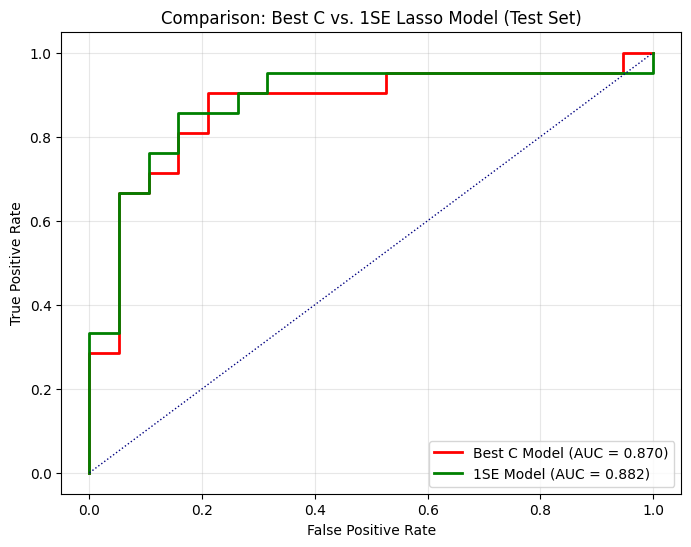

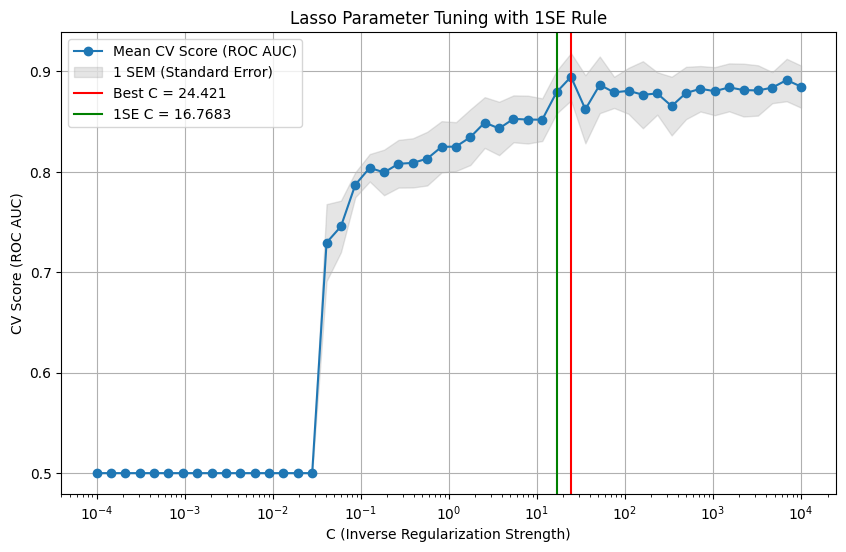

In [11]:

# 3. Create Common Plot
plt.figure(figsize=(8, 6))

# Curve 1: Best C (e.g., in Blue)
plt.plot(fpr_best_test, tpr_best_test, color='red', lw=2, 
         label=f'Best C Model (AUC = {auc_best_test:.3f})')

# Kurve 2: 1SE Model (z.B. in Grün oder Orange)
plt.plot(fpr_1se_test, tpr_1se_test, color='green', lw=2,
         label=f'1SE Model (AUC = {auc_1se_test:.3f})')

# Diagonale (Zufallslinie)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle=':')

plt.title('Comparison: Best C vs. 1SE Lasso Model (Test Set)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig(f"/labmed/workspace/lotta/finaletoolkit/outputs/plots/{SPECIFIC_GROUP_FILE}/{BIN_SIZE}/roc_curve_both.png")


plt.show()

# --- Lasso Parameter Tuning Plot ---
plt.figure(figsize=(10,6))
plt.semilogx(cs, mean_scores, marker='o', label='Mean CV Score (ROC AUC)')
plt.fill_between(cs, mean_scores - sem_scores, mean_scores + sem_scores, alpha=0.2, color='gray', label='1 SEM (Standard Error)')
plt.axvline(best_c, color='r', label=f'Best C = {best_c:.3f}')
plt.axvline(c_1se, color='g', label=f'1SE C = {c_1se:.4f}')
plt.title("Lasso Parameter Tuning with 1SE Rule")
plt.xlabel("C (Inverse Regularization Strength)")
plt.ylabel("CV Score (ROC AUC)")
plt.legend()
plt.grid(True)
plt.savefig(f"/labmed/workspace/lotta/finaletoolkit/outputs/plots/{SPECIFIC_GROUP_FILE}/{BIN_SIZE}/lasso_parameter_tuning.png")
plt.show()


stability_df_output['test auc c'] = auc_best_test
stability_df_output['test auc 1se'] = auc_1se_test




## 5.2 Training vs. Test with best model 

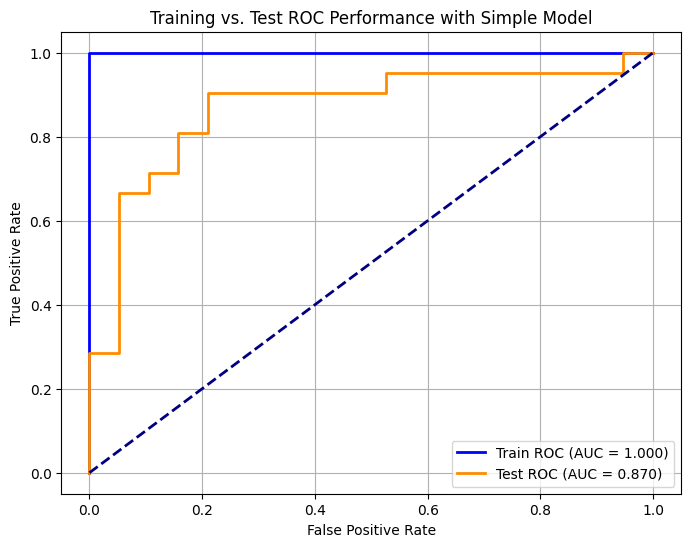

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_best_train, tpr_best_train, color='blue', lw=2, label=f'Train ROC (AUC = {auc_best_train:.3f})')
plt.plot(fpr_best_test, tpr_best_test, color='darkorange', lw=2, label=f'Test ROC (AUC = {auc_best_test:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.title('Training vs. Test ROC Performance with Simple Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig(f"/labmed/workspace/lotta/finaletoolkit/outputs/plots/{SPECIFIC_GROUP_FILE}/{BIN_SIZE}/Training_Test_BEST_C.png")

plt.show()
stability_df_output['train auc c'] = auc_best_train

## 5.3 Training vs. Test with 1SE Model

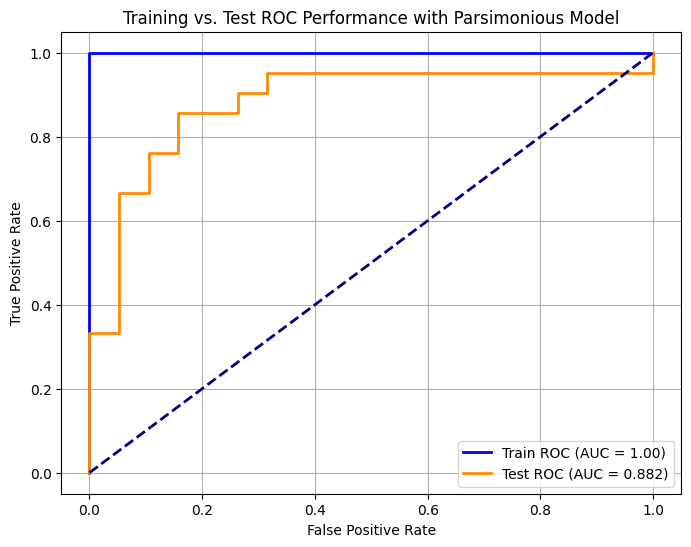

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_1se_train, tpr_1se_train, color='blue', lw=2, label=f'Train ROC (AUC = {auc_1se_train:.2f})')
plt.plot(fpr_1se_test, tpr_1se_test, color='darkorange', lw=2, label=f'Test ROC (AUC = {auc_1se_test:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.title('Training vs. Test ROC Performance with Parsimonious Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig(f"/labmed/workspace/lotta/finaletoolkit/outputs/plots/{SPECIFIC_GROUP_FILE}/{BIN_SIZE}/Training_Test_1SE_C.png")
plt.show()

stability_df_output['train auc 1se'] = auc_1se_train

# 6. Selected Important Features


## 6.1 Pipeline with best model

                Feature  Coefficient
0     mean_chr10_100000     0.000000
1  mean_chr10_100950000     0.000000
2  mean_chr10_101050000     0.054366
3  mean_chr10_101400000     0.000000
4  mean_chr10_101550000     0.000000
SINGLE MODEL (Best C)
Number of Important Features (Best Model): 469

Top Features (Best Model - Positive = Indicative for Cancer):


<Axes: title={'center': 'Top Features (Best Model - Positive = Indicative for Cancer)'}, ylabel='Feature'>

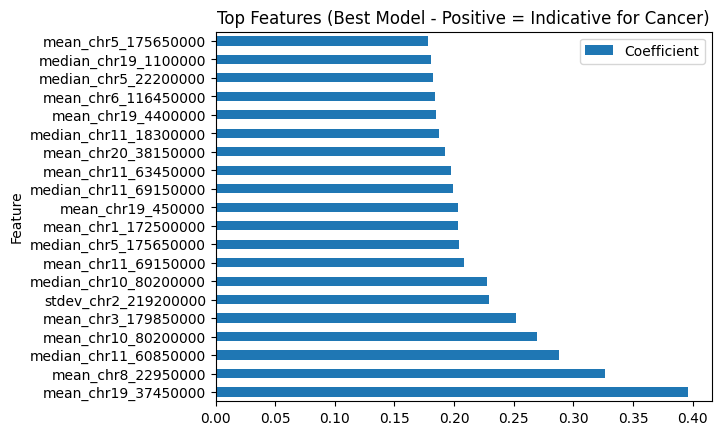

In [14]:
from cv_lasso_single_fold import cross_validation, analyze_feature_stability, plot_roc_curves, plot_auc_boxplot

lasso_model = simple_pipeline.named_steps['lasso_cv']

coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": lasso_model.coef_[0]
})
print(coef_df.head())
important_features = coef_df[coef_df["Coefficient"] != 0].sort_values(by="Coefficient", ascending=False)

print("SINGLE MODEL (Best C)")
print(f"Number of Important Features (Best Model): {len(important_features)}")
print("\nTop Features (Best Model - Positive = Indicative for Cancer):")
important_features.head(20).plot.barh(x="Feature", y="Coefficient", title="Top Features (Best Model - Positive = Indicative for Cancer)")


## 6.2 Stable Pipeline with 1SE model 


STABLE MODEL (c_1se):
Number of Important Features (Stable Model): 403

Top Features (Stable Model - Positive = Indicative for Cancer):


COMPARISON:
Best C Model: 469 features selected
1SE Model:    403 features selected
Difference:   66 fewer features in 1SE model
stable_important_features:                      Feature  Coefficient
1693     mean_chr19_37450000     0.410208
4615   median_chr11_60850000     0.333644
7634   median_chr5_175650000     0.327214
1730       mean_chr19_450000     0.295548
157      mean_chr10_80200000     0.290806
...                      ...          ...
10522    stdev_chr1_16950000    -0.387028
9071   stdev_chr12_131650000    -0.404389
5242   median_chr15_45600000    -0.411001
11888   stdev_chr5_171350000    -0.424257
10426   stdev_chr1_144150000    -0.557767

[403 rows x 2 columns]


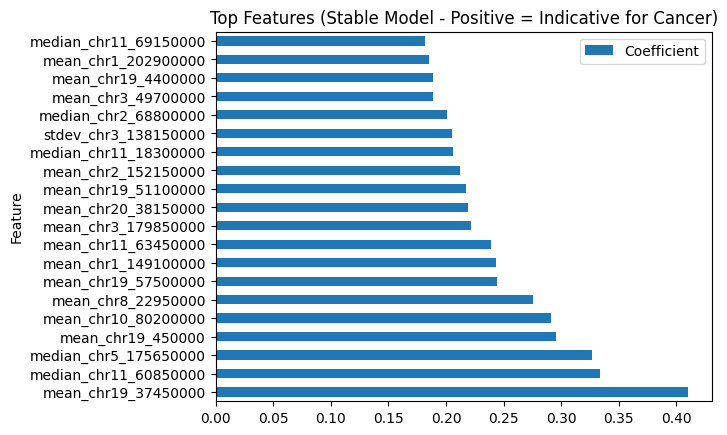

In [15]:

stable_model = stable_pipeline.named_steps['stable_model']

stable_coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": stable_model.coef_[0]
})

stable_important_features = stable_coef_df[stable_coef_df["Coefficient"] != 0].sort_values(by="Coefficient", ascending=False)

print("STABLE MODEL (c_1se):")
print(f"Number of Important Features (Stable Model): {len(stable_important_features)}")
print(f"\nTop Features (Stable Model - Positive = Indicative for Cancer):")
stable_important_features.head(20).plot.barh(x="Feature", y="Coefficient", title="Top Features (Stable Model - Positive = Indicative for Cancer)")

print("\n")
print("COMPARISON:")
print(f"Best C Model: {len(important_features)} features selected")
print(f"1SE Model:    {len(stable_important_features)} features selected")
print(f"Difference:   {len(important_features) - len(stable_important_features)} fewer features in 1SE model")

print(f"stable_important_features: {stable_important_features}")


# 7. Feature Stability Analysis (Cross-Validation) 


Running 5-Fold Cross-Validation for Feature Stability.
Fold 1/5...
  AUC = 0.820, Best C = 6866.488450042998
Fold 2/5...
  AUC = 0.887, Best C = 1048.1131341546852
Fold 3/5...
  AUC = 0.824, Best C = 1526.4179671752302
Fold 4/5...
  AUC = 0.879, Best C = 719.6856730011514
Fold 5/5...
  AUC = 0.858, Best C = 2222.996482526191


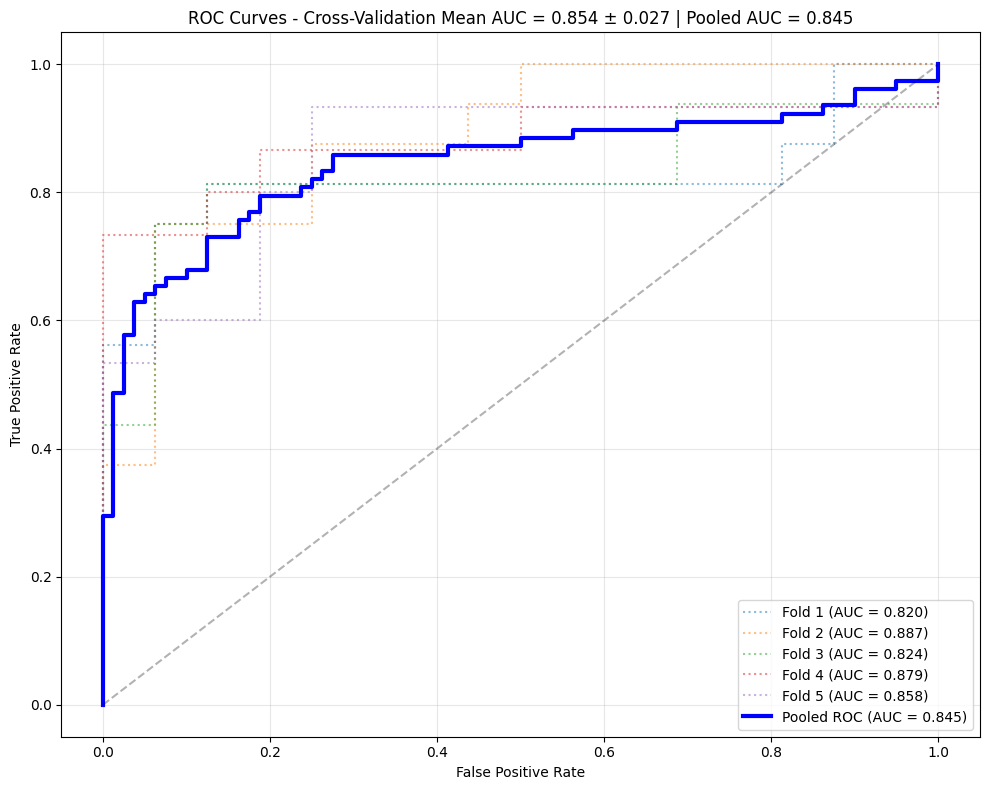

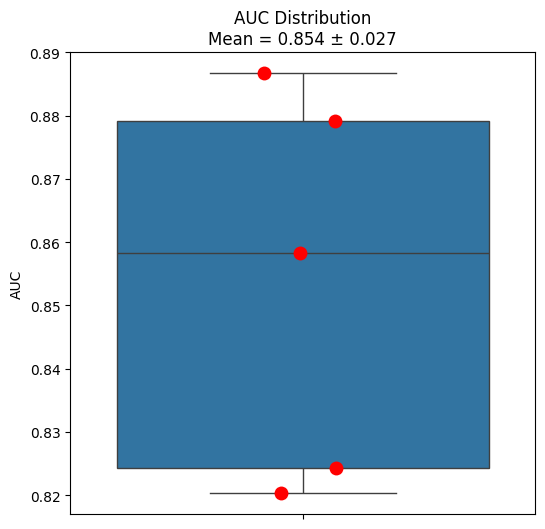

In [16]:
import importlib
import cv_lasso_single_fold
importlib.reload(cv_lasso_single_fold)
from cv_lasso_single_fold import plot_roc_curves, plot_auc_boxplot
print("Running 5-Fold Cross-Validation for Feature Stability.")


# hier macht es keinen sinn die stable pipeline zu nutzen, da in jedem fold mit dem gleichen c wert (c_1se) trainiert wird
cv_results = cross_validation(X_train, y_train, simple_pipeline, n_folds=5)

plot_roc_curves(cv_results, SPECIFIC_GROUP_FILE)
plot_auc_boxplot(cv_results, SPECIFIC_GROUP_FILE)


## 7.2 Table with Statistical Values

In [17]:
from cv_lasso_single_fold import print_performance_table
stat_table = print_performance_table(cv_results)
print(stat_table)

#speicher die stat tabelle
stat_table.to_csv(f"/labmed/workspace/lotta/finaletoolkit/outputs/tables/stat_table_{BIN_SIZE}_{SPECIFIC_GROUP_FILE}.csv", index=False)

'''
Accuracy: Anteil korrekt klassifizierter Samples
Sensitivity: Wie viele Krebs-Patienten wurden erkannt (wichtig!)
Specificity: Wie viele Gesunde wurden korrekt erkannt
Precision: Von allen als "Krebs" vorhergesagten, wie viele waren wirklich Krebs
'''


   Fold       AUC  Accuracy  Sensitivity  Specificity  Precision       Best_C  \
0     1  0.820312  0.781250     0.625000     0.937500   0.909091  6866.488450   
1     2  0.886719  0.812500     0.687500     0.937500   0.916667  1048.113134   
2     3  0.824219  0.812500     0.812500     0.812500   0.812500  1526.417967   
3     4  0.879167  0.806452     0.866667     0.750000   0.764706   719.685673   
4     5  0.858333  0.741935     0.666667     0.812500   0.769231  2222.996483   
5  Mean  0.853750  0.790927     0.731667     0.850000   0.834439  2476.740341   
6   Std  0.030595  0.030272     0.102850     0.083853   0.074045  2518.213842   

    N_Features  
0  2258.000000  
1  1124.000000  
2  1436.000000  
3   880.000000  
4  3065.000000  
5  1752.600000  
6   899.253468  


'\nAccuracy: Anteil korrekt klassifizierter Samples\nSensitivity: Wie viele Krebs-Patienten wurden erkannt (wichtig!)\nSpecificity: Wie viele Gesunde wurden korrekt erkannt\nPrecision: Von allen als "Krebs" vorhergesagten, wie viele waren wirklich Krebs\n'

## 7.3 Feature Stability Analyse



Top Stable Features (Selected across multiple folds):
                    Feature  Frequency  Frequency_Percent  Mean_Coef
1312  median_chr22_29300000          5              100.0   0.329013
732      mean_chr9_87750000          5              100.0   0.252208
414      mean_chr1_74050000          5              100.0   0.247960
73      mean_chr11_86300000          5              100.0   0.229082
799   median_chr11_17350000          5              100.0   0.188608


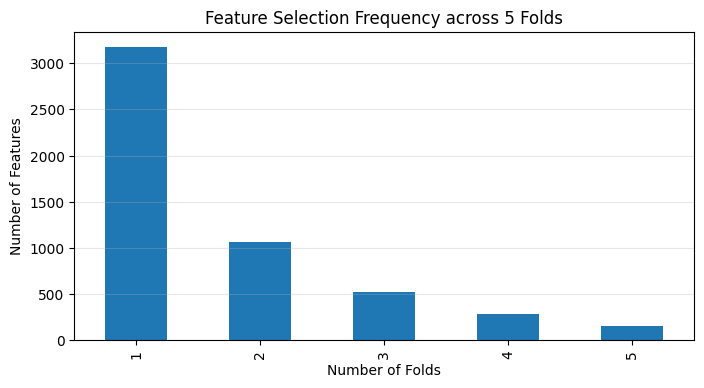

Features in ALL 5 folds: 154


In [18]:
stability_df = analyze_feature_stability(cv_results)

stable_in_all = stability_df[stability_df['Frequency'] == 5]
print("\nTop Stable Features (Selected across multiple folds):")
print(stability_df.head(5))


plt.figure(figsize=(8, 4))
stability_df['Frequency'].value_counts().sort_index().plot(kind='bar')
plt.title('Feature Selection Frequency across 5 Folds')
plt.xlabel('Number of Folds')
plt.ylabel('Number of Features')
plt.grid(axis='y', alpha=0.3)
plt.savefig(f"/labmed/workspace/lotta/finaletoolkit/outputs/plots/{SPECIFIC_GROUP_FILE}/{BIN_SIZE}/feature_selection_frequency.png")
plt.show()
print(f"Features in ALL 5 folds: {len(stable_in_all)}")

## 7.4 Feature Overlap Heatmap 


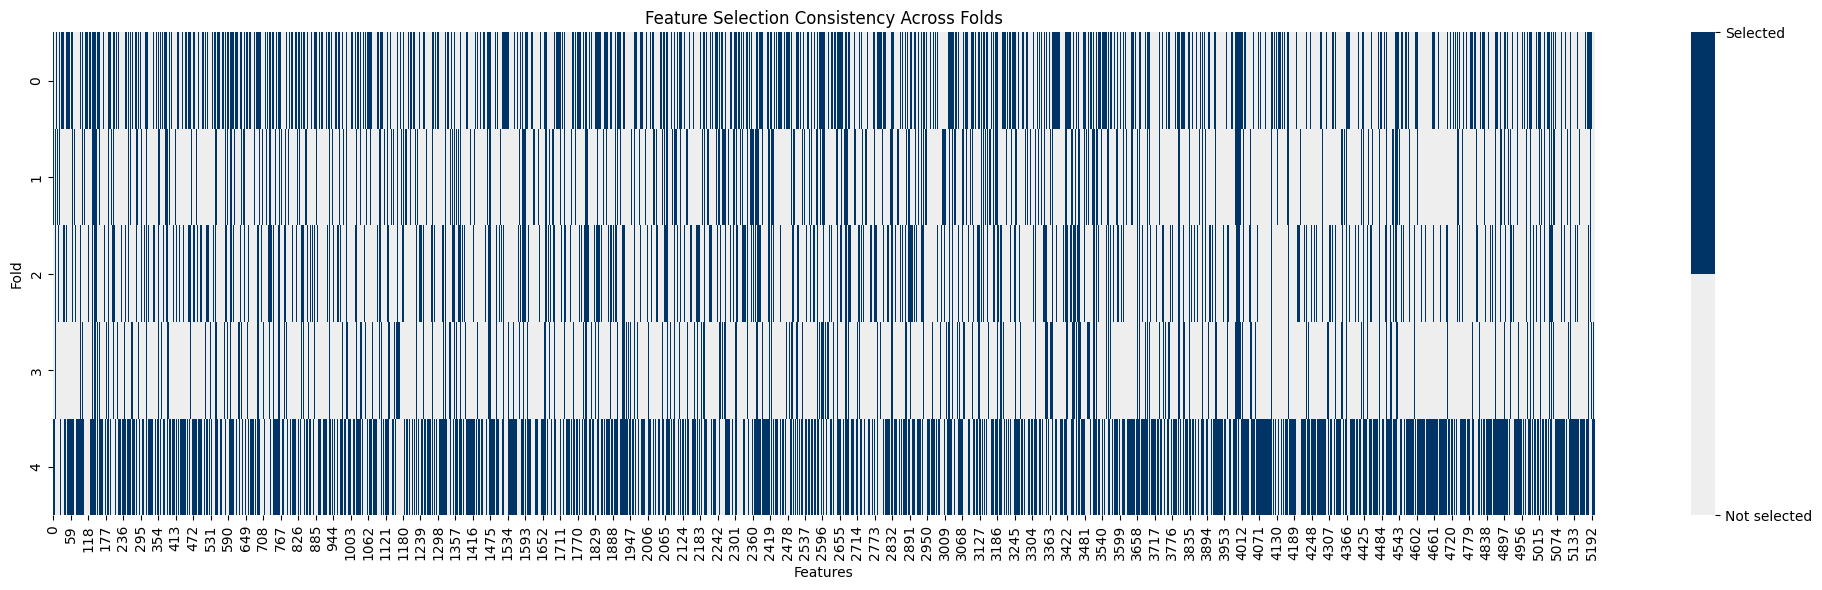

In [19]:
all_features = sorted(list({
    feat
    for e in cv_results
    for feat in e['selected_features'].keys()
}))

matrix = np.zeros((5, len(all_features)))

for i, e in enumerate(cv_results):
    for j, feat in enumerate(all_features):
        if feat in e['selected_features']:
            matrix[i, j] = 1

# --- Binary colormap ---
cmap = ListedColormap(["#eeeeee", "#003366"])

plt.figure(figsize=(20, 6))
ax = sns.heatmap(
    matrix,
    cmap=cmap,
    vmin=0,
    vmax=1,
    cbar=True,
    cbar_kws={"ticks": [0, 1]}
)

# Custom colorbar labels
colorbar = ax.collections[0].colorbar
colorbar.set_ticklabels(["Not selected", "Selected"])

plt.xlabel("Features")
plt.ylabel("Fold")
plt.title("Feature Selection Consistency Across Folds")
plt.tight_layout()
plt.savefig(f"/labmed/workspace/lotta/finaletoolkit/outputs/plots/{SPECIFIC_GROUP_FILE}/{BIN_SIZE}/feature_selection_heatmap.png")
plt.show()


## 7.5 Saving stable features in file for comparison

In [20]:
import pandas as pd
from itertools import combinations

def extract_genomic_position(feature):
    if 'chr' in feature:
        return feature[feature.index('chr'):]
    return feature

metrics = {
    "mean": "stable_features_['mean']_50000_fold.csv",
    "stdev": "stable_features_['stdev']_50000_fold.csv",
    "wps": "stable_features_['wps_value']_50000_fold.csv",
    "mean_median_stdev": "stable_features_['mean', 'median', 'stdev']_50000_fold.csv"
}

base_path = "/labmed/workspace/lotta/finaletoolkit/outputs/statistics/"

feature_sets = {}

for metric, file in metrics.items():
    df = pd.read_csv(base_path + file)
    cleaned = {extract_genomic_position(f) for f in df['Feature']}
    feature_sets[metric] = cleaned


for (m1, f1), (m2, f2) in combinations(feature_sets.items(), 2):
    intersection = f1 & f2
    print(
        f"Intersection between {m1} and {m2}: "
        f"{len(intersection)} stable features\n{intersection}\n"
    )


Intersection between mean and stdev: 4 stable features
{'chr7_149100000', 'chr1_248500000', 'chr1_202900000', 'chr6_20400000'}

Intersection between mean and wps: 8 stable features
{'chr1_2150000', 'chr1_1600000', 'chr17_75200000', 'chr1_30700000', 'chr8_60950000', 'chr17_4800000', 'chr18_3850000', 'chr8_8950000'}

Intersection between mean and mean_median_stdev: 7 stable features
{'chr1_235300000', 'chr19_6700000', 'chr16_28350000', 'chr9_135700000', 'chr7_63350000', 'chr2_222600000', 'chr15_43650000'}

Intersection between stdev and wps: 0 stable features
set()

Intersection between stdev and mean_median_stdev: 0 stable features
set()

Intersection between wps and mean_median_stdev: 0 stable features
set()



# 8. Visualize the ROC Calculation (Label, Probability)

In [21]:
# 1. Get the probabilities for the test set 
y_prob_test = simple_pipeline.predict_proba(X_test)[:, 1]

# 2. Create a DataFrame to map predictions to sample IDs
test_results = pd.DataFrame({
    'Sample_ID': X_test.index,
    'True_Label': y_test,
    'Probability_Cancer': y_prob_test
})

# 3. Sort the results by probability    
test_results = test_results.sort_values(by='Probability_Cancer', ascending=False).reset_index(drop=True)

# 4. Print the top 5 predictions
print("Detailed predicitions for test set:")
print(test_results.head(5))


Detailed predicitions for test set:
  Sample_ID  True_Label  Probability_Cancer
0   EE87884           1            0.999881
1   EE88304           1            0.999777
2   EE87809           1            0.999757
3   EE87881           1            0.999485
4   EE88317           1            0.998645


In [22]:
# Falsch-Negative (Krebs als gesund vorhergesagt)
fn_proben = test_results[(test_results['True_Label'] == 1) & (test_results['Probability_Cancer'] < 0.3)]

# Falsch-Positive (Gesund als Krebs vorhergesagt)
fp_proben = test_results[(test_results['True_Label'] == 0) & (test_results['Probability_Cancer'] > 0.7)]

# Merge outliers with test_results to get the probabilities
outliers_meta = pd.concat([fn_proben, fp_proben])
if not outliers_meta.empty:
    ausreisser_klinik = clinical_df.merge(outliers_meta[['Sample_ID', 'Probability_Cancer', 'True_Label']], 
                                         left_on='Extracted_ID', right_on='Sample_ID')
    print(f"Found outliers with threshold (FN < 0.3, FP > 0.7): {len(ausreisser_klinik)}")
    print(ausreisser_klinik[['Extracted_ID', 'Patient Type', 'Gender', 'Probability_Cancer']])
else:
    print("No outliers found.")


Found outliers with threshold (FN < 0.3, FP > 0.7): 4
  Extracted_ID       Patient Type Gender  Probability_Cancer
0      EE87871  Colorectal Cancer      M            0.028344
1      EE87917     Gastric cancer      M            0.000044
2      EE87968            Healthy      M            0.990647
3      EE87948            Healthy      F            0.763125


In [23]:
stability_df_output.to_csv(f"/labmed/workspace/lotta/finaletoolkit/outputs/tables/stability_df_{BIN_SIZE}_{SPECIFIC_GROUP_FILE}.csv", index=False)